#  Spam Filter with Naive Bayes

In this project I am going to built a spam filter with the Naive Bayes algorithm, based in the Bayes theorem. We will use some messages provided by the UCI Machine Learning Repository to "teach" the computer how to classify this messages. This messages have been already classified as spam or not. This messages have been collected from:

- Grumbletext web site -> A UK forum where users make public claims about SMS spam messages.
- NYS SMS Corpus (NSC) -> Department of Computer Science at the National University of Singapore
- Caroline Tag's PhD Thesis available at http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf

You can download the dataset from the following link: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

# Importing the dataset

First we are going to import the dataset and some python packages for data manipulation as pandas and numpy. 

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['Label', 'SMS'])

Now we are going to explore the dataset and see how many rows and columns it has.

In [355]:
df.shape

(5572, 2)

In [356]:
df

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [358]:
df.describe()

,Label,SMS
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


ham     4825
spam     747
Name: Label, dtype: int64


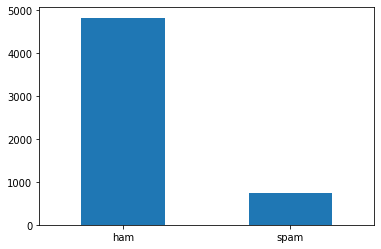

In [359]:
print(df.Label.value_counts())

df.Label.value_counts().plot(kind="bar", rot=0)


Some important information:

The dataset is shaped by 5572 rows and 2 columns

The are no null values.

There are two types of labels for the messsages:
- ham -> Non-spam messages
- spam -> Spam messages

# Messages percentages

We are going to find what are the porcentages for spam and ham messages

In [360]:
df.Label.value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

86.6% of messages are Non-Spam and 13.4% of the messages are Spam.

# Preapering the dataset

Now we are going to split out dataset in two categories:
- Training set -> This dataset will be used to "train" the computer to identify which messages are spam.
- Test set -> We will use it to test how good the spam filter is.

We are going to divide the dataset in the following way:
- Training set will be made up of 80% of the dataset -> 4458 messages.
- Test set will be made up of 20% of the dataset -> 1114 messages.

With this changes, we expect an accurary grater than 80% at detecting spam messages. 

We will start randomizing the dataset that spam and non-spam messages are spread throughout the dataset.

In [361]:
randomized = df.sample(frac=1, random_state=1)

training_len = int(round(len(df)*0.8,0))
test_len = len(df)

training_set = df[:4458].reset_index(drop=True)
test_set = df[training_len:test_len].reset_index(drop=True)

print("The rows and columns of the training set are: ", training_set.shape)
print("The rows and columns of the test set are: ", test_set.shape)

The rows and columns of the training set are:  (4458, 2)
The rows and columns of the test set are:  (1114, 2)


Now we are going to find the spam and non-spam percentages in both sets.

In [362]:
spams_ham_list_train = training_set.Label.value_counts(normalize=True).values.tolist()
ham_training = spams_ham_list_train[0]*100
spam_training = spams_ham_list_train[1]*100

print("---------Training dataset---------")
print("Non-Spam percentage: {}\nSpam percentage: {}".format(ham_training,spam_training))
print("----------------------------------\n")

spams_ham_list_test = test_set.Label.value_counts(normalize=True).values.tolist()
ham_test = spams_ham_list_test[0]*100
spam_test = spams_ham_list_test[1]*100

print("---------Test dataset---------")
print("Non-Spam percentage: {}\nSpam percentage: {}".format(ham_test,spam_test))
print("----------------------------------\n")

---------Training dataset---------
Non-Spam percentage: 86.49618663077612
Spam percentage: 13.503813369223867
----------------------------------

---------Test dataset---------
Non-Spam percentage: 86.983842010772
Spam percentage: 13.016157989228008
----------------------------------



We can see in the results that both datasets have very similar percentages.

In [363]:
test_set.Label.value_counts(normalize=True)

ham     0.869838
spam    0.130162
Name: Label, dtype: float64

# Data Cleaning

We will create a function that will clean both datasets by removing punctuation and tranforming every word from the message to lower case.

In [364]:
def clean_dataset(dataset):
    dataset["SMS"] = dataset["SMS"].str.replace('\W', ' ')
    dataset["SMS"] = dataset["SMS"].str.lower()
    return dataset

training_set = clean_dataset(training_set)
test_set = clean_dataset(test_set)
test_set.head(10)


,Label,SMS
0,ham,aight should i just plan to come up later toni...
1,ham,die i accidentally deleted e msg i suppose ...
2,spam,welcome to uk mobile date this msg is free giv...
3,ham,this is wishing you a great day moji told me ...
4,ham,thanks again for your reply today when is ur ...
5,ham,sorry i flaked last night shit s seriously go...
6,ham,he said i look pretty wif long hair wat but i...
7,ham,ranjith cal drpd deeraj and deepak 5min hold
8,ham,cheers for callin babe sozi culdnt talkbut i w...
9,ham,hey u still at the gym


# Creating the vocabulary

Before we create the Naive Bayes algorithm,we need to create a set of unique words from all the messages.

In [365]:
vocabulary = []

def list_words(x):
    for word in x:
        vocabulary.append(word)
        
training_set["SMS"] = training_set["SMS"].str.split()
training_set["SMS"].apply(list_words)

vocabulary = list(set(vocabulary))
vocabulary

['brains',
 'mahal',
 'claimcode',
 'unconsciously',
 'accordin',
 '310303',
 'ed',
 'bunkers',
 'begins',
 'ashley',
 '2channel',
 'arent',
 'big',
 '7',
 'copies',
 'supplies',
 'dizzamn',
 'luck',
 'sigh',
 'nuerologist',
 'draws',
 '09099725823',
 'naal',
 'project',
 'excited',
 'troubleshooting',
 'correction',
 'er',
 'yaxx',
 'bbq',
 'shadow',
 'tming',
 'endowed',
 'hyde',
 '3mins',
 '5pm',
 'conacted',
 'intrude',
 'po',
 'census',
 'doin',
 'carryin',
 'ee',
 'caught',
 'tendencies',
 'extract',
 '30ish',
 'renting',
 '10ppm',
 'perspective',
 'accessible',
 'ntimate',
 'se',
 'gandhipuram',
 '1st4terms',
 'pure',
 'bang',
 'childish',
 'nigpun',
 'sympathetic',
 'means',
 'lkpobox177hp51fl',
 'receiving',
 'pie',
 'love',
 'chiong',
 'rent',
 's3xy',
 'rajini',
 'saw',
 'l8r',
 'image',
 'outstanding',
 'theatre',
 'frm',
 '49',
 'twins',
 'canal',
 'potato',
 'sometimes',
 'shattered',
 'newsletter',
 'prin',
 'jane',
 'out',
 'arts',
 'ears',
 'jordan',
 'sts',
 'bsn',
 '

# Dataset Transformation

Now we are going to use the vocabulary list to transform out dataset:

![Image of Yaktocat](https://dq-content.s3.amazonaws.com/433/cpgp_dataset_3.png)


Every column, except "Label", will represent the number of times some word is in each message.
For example, in the first message you can see it has the words "secret" and "prize" repeated 2 times and the "claim" and "now" words repeated one time.

For the division of the columns, first we need to create a dictionary, with the unique words being the index and a list representing the number of times a word has repeated in the message.

In [366]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

words_df = pd.DataFrame(word_counts_per_sms)
training_set_clean = pd.concat([training_set, words_df], axis=1)
training_set_clean

,Label,SMS,brains,mahal,claimcode,unconsciously,accordin,310303,ed,bunkers,...,drink,jos,le,sorts,panasonic,chk,cttargg,intend,helpline,5wb
0,ham,"[go, until, jurong, point, crazy, available, o...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[ok, lar, joking, wif, u, oni]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,"[free, entry, in, 2, a, wkly, comp, to, win, f...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[u, dun, say, so, early, hor, u, c, already, t...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[nah, i, don, t, think, he, goes, to, usf, he,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4453,ham,"[i, ve, told, you, everything, will, stop, jus...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4454,ham,"[or, i, guess, lt, gt, min]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4455,ham,"[i, m, home, ard, wat, time, will, u, reach]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4456,ham,"[storming, msg, wen, u, lift, d, phne, u, say,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Naive Bayes Algorithm

Now we are going to build the Naive Bayes algorithm using the following formula:

![title](img/bayes_formula.jpg)

To calculate P(wi|Spam) and P(wi|Ham) we need to use the following formulas:

![title](img/prob_form.jpg)

We will apply Laplace smoothing α to the numerator and denominator so that when one of the probabilities is 0 it doesn't mess up the equation.

First we are going to calculate the constant values:
- P(Spam)
- P(Ham)
- N spam
- N ham
- N vocabulary


In [367]:
#P(Ham)
ham_p = training_set_clean.Label.value_counts(normalize=True).values.tolist()[0]
#P(Spam)
spam_p = training_set_clean.Label.value_counts(normalize=True).values.tolist()[1]

#N ham
n_ham = training_set_clean[training_set_clean["Label"] == "ham"]["SMS"].apply(len).sum()
#N sp
n_spam = training_set_clean[training_set_clean["Label"] == "spam"]["SMS"].apply(len).sum()
#N vocabulary
n_vocabulary = len(vocabulary)
# α
alpha = 1

# Calculating Parameters

Now we are going to calculate the following probabilities:

![title](img/prob_form.jpg)

For each word in the spam or non spam-message, calculate the probability of them appearing in a spam o a non-spam message. 

First we create two dictionaries where the words probabilities are going to go

In [368]:
spam_dic = {word: 0 for word in vocabulary}
ham_dic = {word: 0 for word in vocabulary}

We separate the dataframe in two dataframes by spam and non-spam messages.

In [369]:
ham_messages = training_set_clean[training_set_clean.Label == "ham"]
spam_messages = training_set_clean[training_set_clean.Label == "spam"]

We will calculate the probability that each word of the dictionary appears in a spam or non-spam message.

In [370]:
for i in vocabulary:
    
    #We calculate the probability of the word given that 
    n_word_spam = spam_messages[i].sum()
    n_word_ham = ham_messages[i].sum()
    
    spam_dic[i] = (n_word_spam + alpha) / (n_spam + alpha*n_vocabulary)
    ham_dic[i] = (n_word_ham + alpha) / (n_ham + alpha*n_vocabulary)

# Create the classify function

Now we are going to create a function that classifies a message as Spam o Non-Spam. The steps are going to be:

1. Clean the message.
2. Multiply probabilities and determine the probability of being a Spam or Non-Spam message using Naive Bayes algorithm.
3. Print results.

In [371]:
import re

def classify(message):

    #Message Cleaning:
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    #Defining the probabilities
    p_spam_given_message = spam_p
    p_ham_given_message = ham_p
    
    #Multiplying probabilities
    for word in message:
        if word in spam_dic:
            p_spam_given_message *= spam_dic[word]
        
        if word in ham_dic:
            p_ham_given_message *= ham_dic[word]
    
    #Print percentages
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    #Determine if the message is Spam or Non-Spam
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

Testing the function:

In [372]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.1946675407236375e-25
P(Ham|message): 2.538390052402955e-27
Label: Spam


In [373]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 6.307218028475593e-25
P(Ham|message): 4.417049039139304e-21
Label: Ham


# Spam Filter Accuracy

We are going to measure the accuracy of the spam filter using the test dataset. The accuracy metric will be calculated by dividing the number of correctly classified messages by the total number of classified messsages.

First we will create a function that will be similar to the classify function, but it will return the labels instead of printing them.


In [374]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = spam_p
    p_ham_given_message = ham_p

    for word in message:
        if word in spam_dic:
            p_spam_given_message *= spam_dic[word]
        
        if word in ham_dic:
            p_ham_given_message *= ham_dic[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Applying the function to the dataset:

In [375]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,aight should i just plan to come up later toni...,ham
1,ham,die i accidentally deleted e msg i suppose ...,ham
2,spam,welcome to uk mobile date this msg is free giv...,spam
3,ham,this is wishing you a great day moji told me ...,ham
4,ham,thanks again for your reply today when is ur ...,ham


Measure the accuracy:

In [390]:
total = len(test_set)

correct_list = test_set["predicted"] == test_set["Label"]
correct = correct_list.sum()

In [391]:
accuracy = correct / total
accuracy

0.9856373429084381

# Conclusions

Using the Spam filter in the test dataset, we can see that the model has an accuracy of 98.56%. We meet the objective of having a model with higher precision than 80%. The multinomial Naive Bayes algorithm is very effective at classification problems. This model could be adapted for other problems like detecting false news.

There is still room for improvement and make this spam filter more precise. 